In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torch.nn.functional as F
from torchvision import transforms
from sklearn.metrics import r2_score
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import matplotlib.pyplot as plt

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set training and testing dataset paths
train_folder_paths = [f"Datasets/Breach{i}/{j}" for i in [1, 3, 5, 7, 9] for j in [1, 2, 3]]
test_folder_paths = [f"Datasets/Breach{i}/{j}" for i in [2] for j in [1, 2, 3]]

Transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
])

ROLL_LENGTH = 4  # number of steps for rolling prediction

Using device: cuda


In [ ]:
# 掩膜
mask_data = np.loadtxt('Datasets/Mask.dat')
mask = mask_data[:,2]
mask = mask.reshape(474,320)
mask = np.vstack([mask, np.full((6, 320), 0)])

In [ ]:
def load_data_from_folder(folder_path, shape=(474, 320), length=24):
    # Read .dat files
    file_list = sorted(f for f in os.listdir(folder_path) if f.endswith('.dat'))
    data_list = []
    for file_name in file_list[0:length]:
        file_path = os.path.join(folder_path, file_name)
        try:
            data = np.loadtxt(file_path)
            data_list.append(data)
        except ValueError as e:
            print(f"Cannot read file {file_name}: {e}")

    if not data_list:
        raise ValueError("No valid data found in folder!")

    dx = dy = dt = 1  # unit spacing and time
    all_variables = []

    # Extract elevation from first file
    elevation = data_list[0][:, 2].reshape(shape)
    elevation = np.vstack([elevation, np.full((6, 320), 35)])
    elevation_new = elevation * mask
    elevation_new[elevation_new == 0] = 35
    all_variables.append(elevation_new)

    # Initialize depth at t0 with zeros
    depth_init_0 = np.full((480, 320), 0)
    all_variables.append(depth_init_0)

    # Compute water depth from water level and elevation
    for data in data_list:
        water_level = data[:, 3] - elevation[:474].flatten()
        depth = water_level.reshape(shape)
        depth = np.vstack([depth, np.full((6, 320), 0)]) * mask
        all_variables.append(depth)

    # Extract source terms
    source_variables = []
    for data in data_list:
        source = data[:, 4].reshape(shape)
        source = source * dt / (dx * dy)
        source = np.vstack([source, np.full((6, 320), 0)])
        source_variables.append(source)

    # Average consecutive source terms for smoother input
    source_variables = [np.full((480, 320), 0)] + source_variables
    source_variables1 = [(source_variables[i] + source_variables[i + 1]) / 2 for i in range(length)]
    all_variables = all_variables + source_variables1 + [np.full((480, 320), 0)]

    return all_variables

In [ ]:
class AllVariablesDataset(Dataset):
    def __init__(self, all_variables_list, roll_length=4, transform=Transform):
        self.all_variables_list = [np.copy(item) for item in all_variables_list]
        self.elevation = np.array(self.all_variables_list[0])
        mid_index = (len(self.all_variables_list) - 1) // 2 + 1
        self.depth = np.array(self.all_variables_list[1:mid_index])
        self.source = np.array(self.all_variables_list[mid_index:])
        self.roll_length = roll_length
        self.transform = transform
        self.dataset_length = len(self.depth) - self.roll_length

    def __len__(self):
        return self.dataset_length

    def __getitem__(self, idx):
        # Prepare model input: elevation + depth + source
        seq_depth = [self.depth[idx]]
        seq_source_1 = [self.source[idx]]
        sequence = [self.elevation] + seq_depth + seq_source_1
        sequence = np.stack(sequence, axis=0)
        sequence = torch.tensor(sequence, dtype=torch.float32)

        # Prepare targets and source for rolling prediction
        target_roll = self.depth[idx+1:idx+1+self.roll_length]
        target_roll = torch.tensor(target_roll, dtype=torch.float32)

        source_roll = self.source[idx+1:idx+1+self.roll_length]
        source_roll = torch.tensor(source_roll, dtype=torch.float32)

        if self.transform:
            seed = torch.randint(0, 2**32, (1,)).item()
            torch.manual_seed(seed)
            sequence = self.transform(sequence)
            torch.manual_seed(seed)
            source_roll = self.transform(source_roll)
            torch.manual_seed(seed)
            target_roll = self.transform(target_roll)

        return sequence, source_roll, target_roll

In [ ]:
class MobileResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, expansion=4, dilation=1, dropout_prob=0.0):
        super().__init__()
        expanded_channels = in_channels * expansion
        self.stride = 1
        
        # Inverted residual block: expand -> depthwise -> project
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, expanded_channels, 1, bias=False),  # expand channels
            nn.BatchNorm2d(expanded_channels, track_running_stats=False),
            nn.ReLU6(),
            
            nn.Conv2d(expanded_channels, expanded_channels, 3, 
                      stride=1, padding=dilation, dilation=dilation,
                      groups=expanded_channels, bias=False),  # depthwise conv with dilation
            nn.BatchNorm2d(expanded_channels, track_running_stats=False),
            nn.ReLU6(),
            
            nn.Conv2d(expanded_channels, out_channels, 1, bias=False),  # project channels
            nn.BatchNorm2d(out_channels, track_running_stats=False)
        )
        
        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, bias=False),
                nn.BatchNorm2d(out_channels, track_running_stats=False)
            )
            
        self.dropout = nn.Dropout2d(dropout_prob)
    
    def forward(self, x):
        out = self.conv(x) + self.shortcut(x)
        return self.dropout(F.relu(out))

class LightSE(nn.Module):
    """Lightweight channel attention module"""
    def __init__(self, channel, reduction=8):
        super().__init__()
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel//reduction, bias=False),
            nn.ReLU(),
            nn.Linear(channel//reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.shape
        y = self.avgpool(x).view(b,c)
        y = self.fc(y).view(b,c,1,1)
        return x * y.expand_as(x)

class FloodUNet(nn.Module):
    def __init__(self, dropout_prob=0.0):
        super().__init__()
        ch = [16, 32, 64, 128]  # channel configuration
        
        # Encoder (downsampling path)
        self.encoder1 = nn.Sequential(
            MobileResidualBlock(3, ch[0], dilation=1),
            MobileResidualBlock(ch[0], ch[0], dilation=2),
            LightSE(ch[0])
        )
        self.down1 = nn.Conv2d(ch[0], ch[0], 3, stride=2, padding=1)
        
        self.encoder2 = nn.Sequential(
            MobileResidualBlock(ch[0], ch[1], dilation=1),
            MobileResidualBlock(ch[1], ch[1], dilation=2),
            LightSE(ch[1])
        )
        self.down2 = nn.Conv2d(ch[1], ch[1], 3, stride=2, padding=1)
        
        self.encoder3 = nn.Sequential(
            MobileResidualBlock(ch[1], ch[2], dilation=1),
            MobileResidualBlock(ch[2], ch[2], dilation=2),
            LightSE(ch[2])
        )
        self.down3 = nn.Conv2d(ch[2], ch[2], 3, stride=2, padding=1)
        
        # Bottleneck with large receptive field
        self.bottom = nn.Sequential(
            MobileResidualBlock(ch[2], ch[3], dilation=3),
            MobileResidualBlock(ch[3], ch[3], dilation=5),
            LightSE(ch[3])
        )
        
        # Decoder (upsampling path)
        self.up3 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(ch[3], ch[2], kernel_size=1)
        )
        self.decoder3 = nn.Sequential(
            MobileResidualBlock(ch[2]*2, ch[2]),
            MobileResidualBlock(ch[2], ch[2])
        )
        
        self.up2 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(ch[2], ch[1], kernel_size=1)
        )
        self.decoder2 = nn.Sequential(
            MobileResidualBlock(ch[1]*2, ch[1]),
            MobileResidualBlock(ch[1], ch[1])
        )
        
        self.up1 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(ch[1], ch[0], kernel_size=1)
        )
        self.decoder1 = nn.Sequential(
            MobileResidualBlock(ch[0]*2, ch[0]),
            MobileResidualBlock(ch[0], ch[0])
        )
        
        # Output head
        self.output = nn.Sequential(
            nn.Conv2d(ch[0], 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 1, kernel_size=1),
            nn.ReLU()
        )
        
    def forward(self, x):
        # Encode
        e1 = self.encoder1(x)      # [16, 480,320]
        d1 = self.down1(e1)        # [16, 240,160]
        
        e2 = self.encoder2(d1)     # [32, 240,160]
        d2 = self.down2(e2)        # [32, 120,80]
        
        e3 = self.encoder3(d2)     # [64, 120,80]
        d3 = self.down3(e3)        # [64, 60,40]
        
        # Bottleneck
        b = self.bottom(d3)        # [128, 60,40]
        
        # Decode
        u3 = self.up3(b)           # [64, 120,80]
        cat3 = torch.cat([e3, u3], dim=1)
        dec3 = self.decoder3(cat3) # [64, 120,80]
        
        u2 = self.up2(dec3)        # [32, 240,160]
        cat2 = torch.cat([e2, u2], dim=1)
        dec2 = self.decoder2(cat2) # [32, 240,160]
        
        u1 = self.up1(dec2)        # [16, 480,320]
        cat1 = torch.cat([e1, u1], dim=1)
        dec1 = self.decoder1(cat1) # [16, 480,320]
        
        return self.output(dec1)   # [1, 480,320]

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder (downsampling)
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),  # downsample by 2
            
            nn.Conv2d(16, 32, 5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # downsample by 4
            
            nn.Conv2d(32, 64, 5, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # downsample by 8
        )
        
        # Decoder (upsampling)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 2, stride=2),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            
            nn.ConvTranspose2d(32, 16, 2, stride=2),
            nn.Conv2d(16, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            
            nn.ConvTranspose2d(16, 1, 2, stride=2),
            nn.ReLU()  # ensure non-negative output
        )

    def forward(self, x):
        x = self.encoder(x)
        return self.decoder(x)

# Basic UNet-like model
class ConvBlock(nn.Module):
    """Basic convolutional block"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class SimpleUNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder
        self.enc1 = ConvBlock(3, 16)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = ConvBlock(16, 32)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = ConvBlock(32, 64)
        self.pool3 = nn.MaxPool2d(2)
        
        # Bottleneck
        self.bottleneck = ConvBlock(64, 128)
        
        # Decoder
        self.up3 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec3 = ConvBlock(128, 64)
        self.up2 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.dec2 = ConvBlock(64, 32)
        self.up1 = nn.ConvTranspose2d(32, 16, 2, stride=2)
        self.dec1 = ConvBlock(32, 16)
        
        # Output layer
        self.output = nn.Conv2d(16, 1, 1)
        self.final_act = nn.ReLU()  # ensure non-negative output

    def forward(self, x):
        # Encode
        e1 = self.enc1(x)                # [16, H, W]
        e2 = self.enc2(self.pool1(e1))   # [32, H/2, W/2]
        e3 = self.enc3(self.pool2(e2))   # [64, H/4, W/4]
        
        # Bottleneck
        b = self.bottleneck(self.pool3(e3))  # [128, H/8, W/8]
        
        # Decode
        d3 = self.up3(b)                     # [64, H/4, W/4]
        d3 = torch.cat([e3, d3], dim=1)      # [128, H/4, W/4]
        d3 = self.dec3(d3)                   # [64, H/4, W/4]
        
        d2 = self.up2(d3)                    # [32, H/2, W/2]
        d2 = torch.cat([e2, d2], dim=1)      # [64, H/2, W/2]
        d2 = self.dec2(d2)                   # [32, H/2, W/2]
        
        d1 = self.up1(d2)                    # [16, H, W]
        d1 = torch.cat([e1, d1], dim=1)      # [32, H, W]
        d1 = self.dec1(d1)                   # [16, H, W]
        
        return self.final_act(self.output(d1))  # [1, H, W]


In [ ]:
class NoResidualBlock(nn.Module):
    """Standard convolutional block without residuals"""
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, dilation=1, dropout_prob=0.0):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, dilation=dilation, bias=False),
            nn.BatchNorm2d(out_channels, track_running_stats=False),
            nn.ReLU(inplace=True)
        )
        self.dropout = nn.Dropout2d(dropout_prob)

    def forward(self, x):
        return self.dropout(self.conv(x))

class NoAttentionFloodUNet(nn.Module):
    """Ablation model: removes channel attention modules"""
    def __init__(self, dropout_prob=0.0):
        super().__init__()
        ch = [16, 32, 64, 128]

        # Encoder (LightSE removed)
        self.encoder1 = nn.Sequential(
            MobileResidualBlock(3, ch[0], dilation=1),
            MobileResidualBlock(ch[0], ch[0], dilation=2)
        )
        self.down1 = nn.Conv2d(ch[0], ch[0], 3, stride=2, padding=1)

        self.encoder2 = nn.Sequential(
            MobileResidualBlock(ch[0], ch[1], dilation=1),
            MobileResidualBlock(ch[1], ch[1], dilation=2)
        )
        self.down2 = nn.Conv2d(ch[1], ch[1], 3, stride=2, padding=1)

        self.encoder3 = nn.Sequential(
            MobileResidualBlock(ch[1], ch[2], dilation=1),
            MobileResidualBlock(ch[2], ch[2], dilation=2)
        )
        self.down3 = nn.Conv2d(ch[2], ch[2], 3, stride=2, padding=1)

        # Bottleneck
        self.bottom = nn.Sequential(
            MobileResidualBlock(ch[2], ch[3], dilation=3),
            MobileResidualBlock(ch[3], ch[3], dilation=5)
        )

        # Decoder (same as FloodUNet)
        self.up3 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(ch[3], ch[2], kernel_size=1)
        )
        self.decoder3 = nn.Sequential(
            MobileResidualBlock(ch[2]*2, ch[2]),
            MobileResidualBlock(ch[2], ch[2])
        )

        self.up2 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(ch[2], ch[1], kernel_size=1)
        )
        self.decoder2 = nn.Sequential(
            MobileResidualBlock(ch[1]*2, ch[1]),
            MobileResidualBlock(ch[1], ch[1])
        )

        self.up1 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(ch[1], ch[0], kernel_size=1)
        )
        self.decoder1 = nn.Sequential(
            MobileResidualBlock(ch[0]*2, ch[0]),
            MobileResidualBlock(ch[0], ch[0])
        )

        # Output layer
        self.output = nn.Sequential(
            nn.Conv2d(ch[0], 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 1, kernel_size=1),
            nn.ReLU()
        )

    def forward(self, x):
        e1 = self.encoder1(x)
        d1 = self.down1(e1)
        e2 = self.encoder2(d1)
        d2 = self.down2(e2)
        e3 = self.encoder3(d2)
        d3 = self.down3(e3)
        b = self.bottom(d3)
        u3 = self.up3(b)
        dec3 = self.decoder3(torch.cat([e3, u3], dim=1))
        u2 = self.up2(dec3)
        dec2 = self.decoder2(torch.cat([e2, u2], dim=1))
        u1 = self.up1(dec2)
        dec1 = self.decoder1(torch.cat([e1, u1], dim=1))
        return self.output(dec1)


class NoResidualFloodUNet(nn.Module):
    """Ablation model: removes residual connections, retains attention"""
    def __init__(self, dropout_prob=0.0):
        super().__init__()
        ch = [16, 32, 64, 128]

        # Encoder with attention (no residuals)
        self.enc1 = nn.Sequential(
            nn.Conv2d(3, ch[0], 3, padding=1, bias=False),
            nn.BatchNorm2d(ch[0], track_running_stats=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch[0], ch[0], 3, padding=1, bias=False),
            nn.BatchNorm2d(ch[0], track_running_stats=False),
            nn.ReLU(inplace=True),
            LightSE(ch[0])
        )
        self.down1 = nn.Conv2d(ch[0], ch[0], 3, stride=2, padding=1)

        self.enc2 = nn.Sequential(
            nn.Conv2d(ch[0], ch[1], 3, padding=1, bias=False),
            nn.BatchNorm2d(ch[1], track_running_stats=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch[1], ch[1], 3, padding=1, bias=False),
            nn.BatchNorm2d(ch[1], track_running_stats=False),
            nn.ReLU(inplace=True),
            LightSE(ch[1])
        )
        self.down2 = nn.Conv2d(ch[1], ch[1], 3, stride=2, padding=1)

        self.enc3 = nn.Sequential(
            nn.Conv2d(ch[1], ch[2], 3, padding=1, bias=False),
            nn.BatchNorm2d(ch[2], track_running_stats=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch[2], ch[2], 3, padding=1, bias=False),
            nn.BatchNorm2d(ch[2], track_running_stats=False),
            nn.ReLU(inplace=True),
            LightSE(ch[2])
        )
        self.down3 = nn.Conv2d(ch[2], ch[2], 3, stride=2, padding=1)

        # Bottleneck
        self.bottom = nn.Sequential(
            nn.Conv2d(ch[2], ch[3], 3, padding=1, bias=False),
            nn.BatchNorm2d(ch[3], track_running_stats=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch[3], ch[3], 3, padding=1, bias=False),
            nn.BatchNorm2d(ch[3], track_running_stats=False),
            nn.ReLU(inplace=True),
            LightSE(ch[3])
        )

        # Decoder
        self.up3 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(ch[3], ch[2], 1, bias=False)
        )
        self.dec3 = nn.Sequential(
            nn.Conv2d(ch[2]*2, ch[2], 3, padding=1, bias=False),
            nn.BatchNorm2d(ch[2], track_running_stats=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch[2], ch[2], 3, padding=1, bias=False),
            nn.BatchNorm2d(ch[2], track_running_stats=False),
            nn.ReLU(inplace=True)
        )

        self.up2 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(ch[2], ch[1], 1, bias=False)
        )
        self.dec2 = nn.Sequential(
            nn.Conv2d(ch[1]*2, ch[1], 3, padding=1, bias=False),
            nn.BatchNorm2d(ch[1], track_running_stats=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch[1], ch[1], 3, padding=1, bias=False),
            nn.BatchNorm2d(ch[1], track_running_stats=False),
            nn.ReLU(inplace=True)
        )

        self.up1 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(ch[1], ch[0], 1, bias=False)
        )
        self.dec1 = nn.Sequential(
            nn.Conv2d(ch[0]*2, ch[0], 3, padding=1, bias=False),
            nn.BatchNorm2d(ch[0], track_running_stats=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch[0], ch[0], 3, padding=1, bias=False),
            nn.BatchNorm2d(ch[0], track_running_stats=False),
            nn.ReLU(inplace=True)
        )

        # Output
        self.output = nn.Sequential(
            nn.Conv2d(ch[0], 8, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(8, 1, 1),
            nn.ReLU(inplace=True)
        )
        self.dropout = nn.Dropout2d(dropout_prob)

    def forward(self, x):
        e1 = self.enc1(x)
        d1 = self.down1(e1)
        e2 = self.enc2(d1)
        d2 = self.down2(e2)
        e3 = self.enc3(d2)
        d3 = self.down3(e3)
        b = self.bottom(d3)
        u3 = self.up3(b)
        dec3 = self.dec3(torch.cat([e3, u3], dim=1))
        u2 = self.up2(dec3)
        dec2 = self.dec2(torch.cat([e2, u2], dim=1))
        u1 = self.up1(dec2)
        dec1 = self.dec1(torch.cat([e1, u1], dim=1))
        out = self.output(dec1)
        return self.dropout(out)

    
class PlainFloodUNet(nn.Module):
    """Ablation model: no residuals, no attention modules"""
    def __init__(self, dropout_prob=0.0):
        super().__init__()
        ch = [16, 32, 64, 128]

        # Encoder
        self.enc1 = nn.Sequential(
            NoResidualBlock(3, ch[0], dropout_prob=dropout_prob),
            NoResidualBlock(ch[0], ch[0], dropout_prob=dropout_prob)
        )
        self.down1 = nn.Conv2d(ch[0], ch[0], kernel_size=3, stride=2, padding=1)

        self.enc2 = nn.Sequential(
            NoResidualBlock(ch[0], ch[1], dropout_prob=dropout_prob),
            NoResidualBlock(ch[1], ch[1], dropout_prob=dropout_prob)
        )
        self.down2 = nn.Conv2d(ch[1], ch[1], kernel_size=3, stride=2, padding=1)

        self.enc3 = nn.Sequential(
            NoResidualBlock(ch[1], ch[2], dropout_prob=dropout_prob),
            NoResidualBlock(ch[2], ch[2], dropout_prob=dropout_prob)
        )
        self.down3 = nn.Conv2d(ch[2], ch[2], kernel_size=3, stride=2, padding=1)

        # Bottleneck
        self.bottom = nn.Sequential(
            NoResidualBlock(ch[2], ch[3], dropout_prob=dropout_prob),
            NoResidualBlock(ch[3], ch[3], dropout_prob=dropout_prob)
        )

        # Decoder
        self.up3 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(ch[3], ch[2], kernel_size=1)
        )
        self.dec3 = nn.Sequential(
            NoResidualBlock(ch[2]*2, ch[2], dropout_prob=dropout_prob),
            NoResidualBlock(ch[2], ch[2], dropout_prob=dropout_prob)
        )

        self.up2 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(ch[2], ch[1], kernel_size=1)
        )
        self.dec2 = nn.Sequential(
            NoResidualBlock(ch[1]*2, ch[1], dropout_prob=dropout_prob),
            NoResidualBlock(ch[1], ch[1], dropout_prob=dropout_prob)
        )

        self.up1 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(ch[1], ch[0], kernel_size=1)
        )
        self.dec1 = nn.Sequential(
            NoResidualBlock(ch[0]*2, ch[0], dropout_prob=dropout_prob),
            NoResidualBlock(ch[0], ch[0], dropout_prob=dropout_prob)
        )

        # Output
        self.output = nn.Sequential(
            nn.Conv2d(ch[0], 8, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(8, 1, kernel_size=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        e1 = self.enc1(x)
        d1 = self.down1(e1)
        e2 = self.enc2(d1)
        d2 = self.down2(e2)
        e3 = self.enc3(d2)
        d3 = self.down3(e3)
        b = self.bottom(d3)
        u3 = self.up3(b)
        dec3 = self.dec3(torch.cat([e3, u3], dim=1))
        u2 = self.up2(dec3)
        dec2 = self.dec2(torch.cat([e2, u2], dim=1))
        u1 = self.up1(dec2)
        dec1 = self.dec1(torch.cat([e1, u1], dim=1))
        return self.output(dec1)

In [ ]:
modellst=[FloodUNet(),SimpleCNN(),SimpleUNet()]
namelist=['FloodUnet','cnn','Unet']
modelist=[]
for i in range(3):
    model= modellst[i].to(device)
    checkpoint = torch.load(namelist[i]+".pth", map_location=device)
    model.load_state_dict(checkpoint['model'])
    model.eval()
    modelist.append(model)

modellst1=[FloodUNet(),NoAttentionFloodUNet(),NoResidualFloodUNet(),PlainFloodUNet()]
namelist1=['FloodUnet','NoAttention','NoResidual','PlainFloodUNet']
modelist1=[]
for i in range(4):
    model= modellst1[i].to(device)
    checkpoint = torch.load(namelist1[i]+".pth", map_location=device)
    model.load_state_dict(checkpoint['model'])
    model.eval()
    modelist1.append(model)

In [ ]:
def getimg(dataloader_paths, model, num_predictions=24):
    mtest_dataloader = iter(DataLoader(
        ConcatDataset([
            AllVariablesDataset(
                load_data_from_folder(p, length=28),
                roll_length=1,
                transform=None
            ) for p in dataloader_paths
        ]),
        batch_size=1,
        shuffle=False
    ))

    inputs, _, targets = next(mtest_dataloader)
    inputs = inputs.to(device)
    input_sequence = inputs

    predicted_images = []
    real_images = []

    for _ in range(num_predictions):
        with torch.no_grad():
            output = model(input_sequence)

        real_image = targets[0].to(device).squeeze(1)
        predicted_images.append(output.squeeze(1).cpu().numpy())
        real_images.append(real_image.cpu().numpy())

        next_input, _, targets = next(mtest_dataloader)
        next_input = next_input.to(device)

        # Update input: [channel0, predicted, next_channel2]
        input_sequence = torch.cat([
            input_sequence[:, [0], :, :],
            output,
            next_input[:, [2], :, :]
        ], dim=1)

    return real_images, predicted_images


In [ ]:
real,list0=getimg(["Datasets/Breach4/4"],modelist[0].to(device),num_predictions=24)
_,list1=getimg(["Datasets/Breach4/4"],modelist[1].to(device),num_predictions=24)
_,list2=getimg(["Datasets/Breach4/4"],modelist[2].to(device),num_predictions=24)

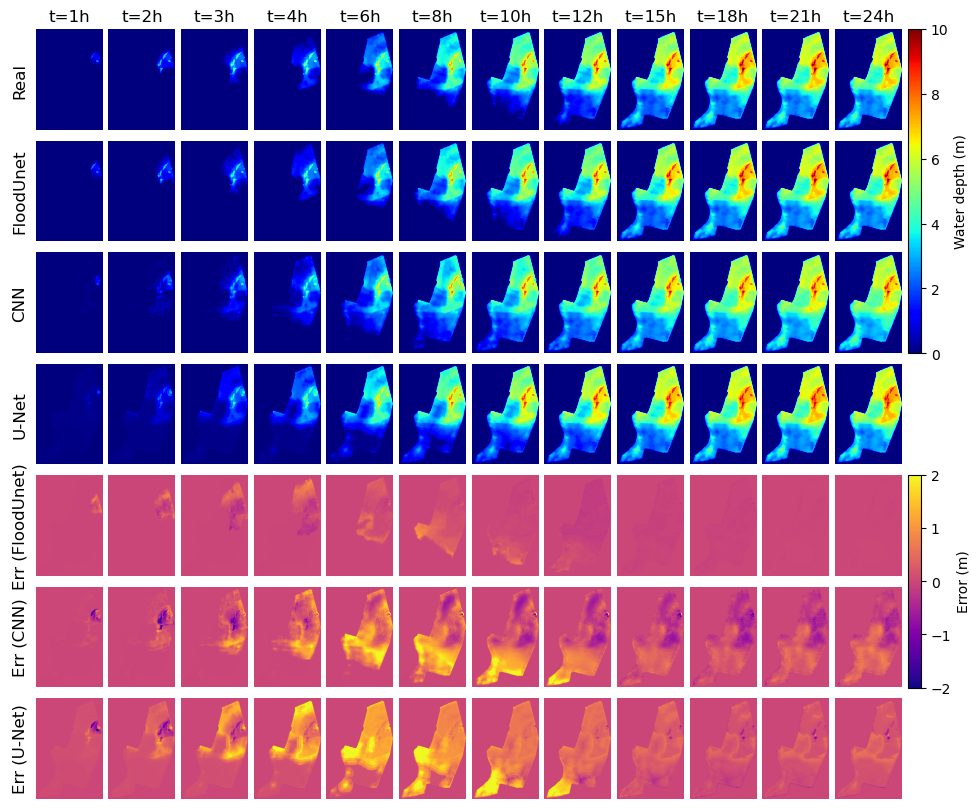

In [ ]:
prelist = [list0, list1, list2]
selected_ts = [1, 2, 3, 4, 6, 8, 10, 12, 15, 18, 21, 24]
indices = [t - 1 for t in selected_ts]

rows, cols = 7, len(indices)
gs = gridspec.GridSpec(rows, cols + 3,
                       width_ratios=[0.3] + [1]*cols + [0.2, 0.2],
                       wspace=0.1, hspace=0.1)

fig = plt.figure(figsize=(cols, 10))
axes = [[fig.add_subplot(gs[r, c + 1]) for c in range(cols)] for r in range(rows)]

for i, idx in enumerate(indices):
    # Row 0: ground truth
    ax_real = axes[0][i]
    im_real = ax_real.imshow(np.flipud(real[idx][0]), cmap='jet', vmin=0, vmax=10)
    ax_real.set_title(f't={idx + 1}h')
    ax_real.axis('off')

    # Row 1–3: predictions
    for j in range(3):
        ax_p = axes[j + 1][i]
        ax_p.imshow(np.flipud(prelist[j][idx][0]), cmap='jet', vmin=0, vmax=10)
        ax_p.axis('off')

    # Row 4–6: errors
    for j in range(3):
        ax_e = axes[4 + j][i]
        err = prelist[j][idx][0] - real[idx][0]
        im_err = ax_e.imshow(np.flipud(err), cmap='plasma', vmin=-2, vmax=2)
        ax_e.axis('off')

# Row labels
row_titles = ['Real', 'FloodUnet', 'CNN', 'U-Net',
              'Err (FloodUnet)', 'Err (CNN)', 'Err (U-Net)']
for r, title in enumerate(row_titles):
    ax_lbl = fig.add_subplot(gs[r, 0])
    ax_lbl.text(0.5, 0.5, title, va='center', ha='center',
                rotation='vertical', fontsize=12)
    ax_lbl.axis('off')

# Colorbars
cax1 = fig.add_subplot(gs[0:3, -2])
fig.colorbar(im_real, cax=cax1, orientation='vertical')
cax1.set_ylabel('Water depth (m)')

cax2 = fig.add_subplot(gs[4:6, -1])
sm = mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=-2, vmax=2), cmap='plasma')
fig.colorbar(sm, cax=cax2, orientation='vertical')
cax2.set_ylabel('Error (m)')

# Align colorbar widths
pos1 = cax1.get_position()
pos2 = cax2.get_position()
x0 = min(pos1.x0, pos2.x0)
width = max(pos1.width, pos2.width)
cax1.set_position([x0, pos1.y0, width, pos1.height])
cax2.set_position([x0, pos2.y0, width, pos2.height])

plt.show()


In [ ]:
def plotmse(model, testlist, threshold=0.05, rolling=True):
    model.eval()
    test_path = f'Datasets/Breach{testlist}/4'
    
    # Load test dataset
    ds = AllVariablesDataset(load_data_from_folder(test_path, length=28),
                             roll_length=1, transform=None)
    loader = iter(DataLoader(ds, batch_size=1, shuffle=False))

    inputs, _, targets = next(loader)
    inputs = inputs.to(device)
    input_sequence = inputs

    num_preds = 24
    pred_list, real_list = []
    area_list = []

    # Rolling prediction
    for _ in range(num_preds):
        with torch.no_grad():
            out = model(input_sequence)

        real = targets[0].to(device).squeeze(1)
        pred = out.squeeze(1)

        pred_list.append(pred.cpu().numpy()[0])
        real_list.append(real.cpu().numpy()[0])

        # Compute flooded area (grid count above threshold)
        flooded_area = np.sum(real.cpu().numpy()[0] > threshold)
        area_list.append(flooded_area)

        nxt, _, targets = next(loader)
        nxt = nxt.to(device)
        if rolling:
            input_sequence = torch.cat([
                input_sequence[:, [0], :, :],
                out,
                nxt[:, [2], :, :]
            ], dim=1)
        else:
            input_sequence = nxt

    mse_tot = []
    fpr_list, fnr_list = []
    precision_list, recall_list = []

    # Evaluation metrics
    for i in range(num_preds):
        real = real_list[i]
        pred = pred_list[i]

        mse_tot.append(np.mean((real - pred) ** 2))

        real_mask = real > threshold
        pred_mask = pred > threshold

        TP = np.logical_and(pred_mask, real_mask).sum()
        FP = np.logical_and(pred_mask, ~real_mask).sum()
        FN = np.logical_and(~pred_mask, real_mask).sum()
        TN = np.logical_and(~pred_mask, ~real_mask).sum()

        fpr = FP / (FP + TN) if (FP + TN) > 0 else 0
        fnr = FN / (FN + TP) if (FN + TP) > 0 else 0
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall    = TP / (TP + FN) if (TP + FN) > 0 else 0

        fpr_list.append(fpr)
        fnr_list.append(fnr)
        precision_list.append(precision)
        recall_list.append(recall)

    return {
        'mse_total': mse_tot,
        'fpr':       fpr_list,
        'fnr':       fnr_list,
        'precision': precision_list,
        'recall':    recall_list,
        'area':      area_list
    }



Region Average Elevations:
Region 1: 21.9955
Region 2: 24.7671
Region 3: 27.8239


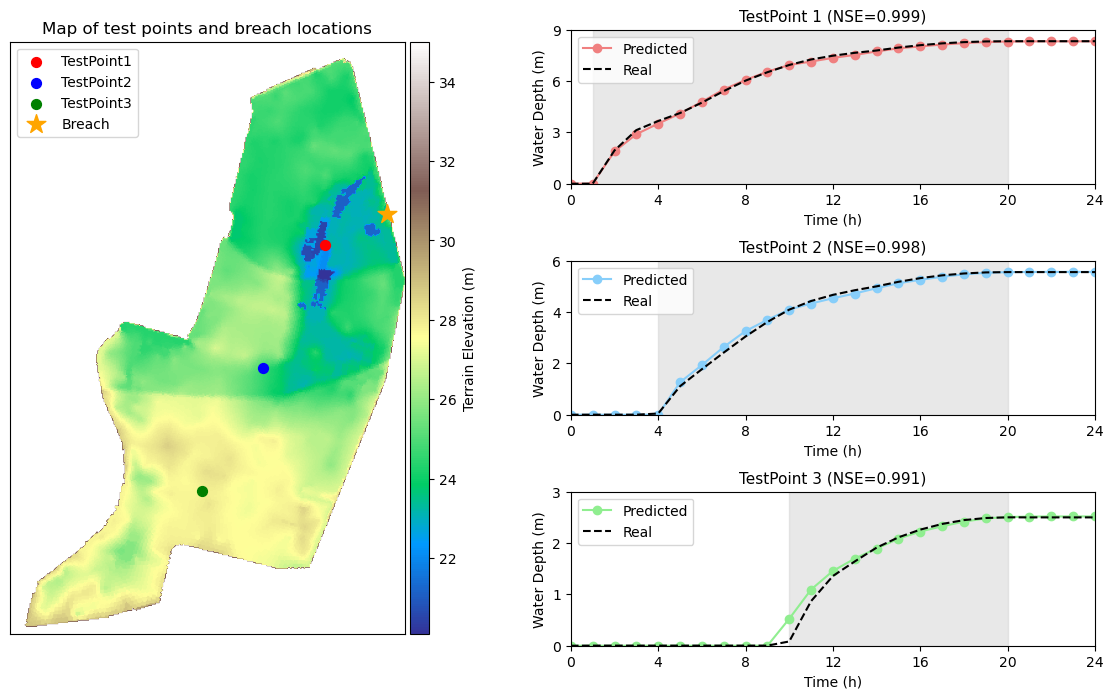

NSE Values: [0.9987230551662147, 0.9979431640802434, 0.9911144938692011]


In [ ]:
def plot_region_depth(model, testlist, regions, circle_pos=None, show_plot=True, highlight_periods=None):
    model.eval()

    # Load dataset
    test_path = f'Datasets/Breach{testlist}/4'
    ds = AllVariablesDataset(
        load_data_from_folder(test_path, length=28),
        roll_length=1, transform=None
    )
    loader = iter(DataLoader(ds, batch_size=1, shuffle=False))
    inputs, _, targets = next(loader)
    inputs = inputs.to(device)
    input_sequence = inputs

    num_preds = 24
    num_regions = len(regions)
    pred_depth_lists = [[] for _ in range(num_regions)]
    real_depth_lists = [[] for _ in range(num_regions)]

    # Rolling prediction
    for _ in range(num_preds):
        with torch.no_grad():
            out = model(input_sequence)
        real = targets[0].to(device).squeeze(1)
        pred = out.squeeze(1)

        # Extract mean water depth for each region
        for i, (x1, x2, y1, y2) in enumerate(regions):
            x2 = x2 if x2 > 0 else real.shape[-1] + x2 + 1
            y2 = y2 if y2 > 0 else real.shape[-2] + y2 + 1

            pred_region = pred[..., y1:y2, x1:x2]
            real_region = real[..., y1:y2, x1:x2]

            pred_depth_lists[i].append(pred_region.mean().item())
            real_depth_lists[i].append(real_region.mean().item())

        # Update input sequence for next step
        nxt, _, targets = next(loader)
        nxt = nxt.to(device)
        input_sequence = torch.cat([
            input_sequence[:, [0], :, :],  # topography
            out,                           # predicted water depth
            nxt[:, [2], :, :]              # source term
        ], dim=1)

    # Report average elevation in each region
    terrain = inputs[0, 0].cpu().numpy()
    print("\nRegion Average Elevations:")
    for i, (x1, x2, y1, y2) in enumerate(regions):
        x2 = x2 if x2 > 0 else terrain.shape[1] + x2 + 1
        y2 = y2 if y2 > 0 else terrain.shape[0] + y2 + 1
        avg_elev = np.mean(terrain[int(y1):int(y2), int(x1):int(x2)])
        print(f"Region {i+1}: {avg_elev:.4f}")

    # Calculate Nash-Sutcliffe Efficiency (NSE)
    nse_list = []
    for real_series, pred_series in zip(real_depth_lists, pred_depth_lists):
        real_arr = np.array(real_series)
        pred_arr = np.array(pred_series)
        num = np.sum((real_arr - pred_arr) ** 2)
        den = np.sum((real_arr - np.mean(real_arr)) ** 2)
        nse = 1 - (num / den) if den != 0 else float('nan')
        nse_list.append(nse)

    if show_plot:
        fig = plt.figure(figsize=(14, 8))
        gs = gridspec.GridSpec(1, 2, width_ratios=[1.2, 1.5], wspace=0.3)

        # --- Left: terrain map + region markers ---
        ax0 = fig.add_subplot(gs[0])
        im = ax0.imshow(terrain, cmap='terrain', origin='lower')
        divider = make_axes_locatable(ax0)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax, label='Terrain Elevation (m)')
        ax0.set_title('Terrain and Region Locations')

        region_colors = ['lightcoral', 'lightskyblue', 'lightgreen']
        point_colors = ['red', 'blue', 'green']

        for i, (x1, x2, y1, y2) in enumerate(regions):
            x2 = x2 if x2 > 0 else terrain.shape[1] + x2 + 1
            y2 = y2 if y2 > 0 else terrain.shape[0] + y2 + 1
            cx = (x1 + x2) / 2
            cy = (y1 + y2) / 2
            ax0.scatter(cx, cy, s=50, c=point_colors[i], marker='o', label=f'TestPoint {i+1}')

        # Optional breach marker
        if circle_pos is None:
            circle_pos = (terrain.shape[1] / 2, terrain.shape[0] / 2)
        ax0.scatter(*circle_pos, s=200, marker='*', c='orange', label='Breach')

        ax0.legend(loc='upper left')
        ax0.set_xticks([])
        ax0.set_yticks([])
        ax0.grid(False)

        # --- Right: time series plots for each region ---
        inner_gs = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs[1], hspace=0.5)
        time_steps = np.arange(0, 25, 4)

        for i in range(3):
            ax = fig.add_subplot(inner_gs[i])
            ax.plot([0] + pred_depth_lists[i], color=region_colors[i], marker='o', label='Predicted')
            ax.plot([0] + real_depth_lists[i], color='black', linestyle='--', label='Real')

            # Optional highlight zone
            if highlight_periods and len(highlight_periods) >= (i+1)*2:
                start = highlight_periods[i*2]
                end = highlight_periods[i*2 + 1]
                ax.axvspan(start, end, color='lightgray', alpha=0.5)

            ax.set_xticks(time_steps)
            ax.set_xlim(0, 24)
            ax.set_xlabel('Time (h)', fontsize=10)

            ymax = max(max(pred_depth_lists[i]), max(real_depth_lists[i]))
            ymax_even = int(np.ceil(ymax))
            ax.set_ylim(0, ymax_even)
            ax.set_yticks(np.arange(0, ymax_even + 1, (ymax_even + 1)//3))
            ax.set_ylabel('Water Depth (m)', fontsize=10)

            ax.set_title(f'TestPoint {i+1} (NSE={nse_list[i]:.3f})', fontsize=11)
            ax.legend()
            ax.grid(False)

        plt.show()

    return {
        'predicted_depths': pred_depth_lists,
        'real_depths': real_depth_lists,
        'nse': nse_list,
        'regions': regions
    }

In [ ]:
def get_pixelwise_depth_pairs_with_r2(model, testlist, show_plot=False, names=''):
    # Build test dataset loader
    test_path = f'Datasets/Breach{testlist[0]}/{testlist[1]}'
    ds = AllVariablesDataset(load_data_from_folder(test_path, length=28),
                             roll_length=1, transform=None)
    loader = iter(DataLoader(ds, batch_size=1, shuffle=False))

    # Initialize input and target
    inputs, _, targets = next(loader)
    inputs = inputs.to(device)
    input_sequence = inputs

    num_preds = 24
    all_pairs = []           # Stores valid (pred, real) pixel pairs per timestep
    r2_scores = []           # R² scores for each timestep
    accumulated_pred = []    # All predictions across time
    accumulated_real = []    # All ground truths across time

    for step in range(num_preds):
        with torch.no_grad():
            out = model(input_sequence)
        real = targets[0].to(device).squeeze(1)
        pred = out.squeeze(1)

        # Flatten to 1D (H * W)
        pred_flat = pred.cpu().numpy().flatten()
        real_flat = real.cpu().numpy().flatten()

        # Exclude (0, 0) pixels
        mask = (pred_flat != 0) | (real_flat != 0)
        filtered_pred = pred_flat[mask]
        filtered_real = real_flat[mask]

        # Save valid pixel pairs for current timestep
        all_pairs.append(np.column_stack((filtered_pred, filtered_real)))

        # Aggregate values for global R² analysis
        accumulated_pred.extend(filtered_pred)
        accumulated_real.extend(filtered_real)

        # Compute R² score
        r2 = r2_score(filtered_real, filtered_pred)
        r2_scores.append(r2)

        # Update input sequence
        nxt, _, targets = next(loader)
        nxt = nxt.to(device)
        input_sequence = torch.cat([
            input_sequence[:, [0], :, :],  # static terrain
            out,                           # model prediction
            nxt[:, [2], :, :]              # external forcing
        ], dim=1)
        input_sequence = nxt  # optionally reset full input

    # Optional scatter plot visualization


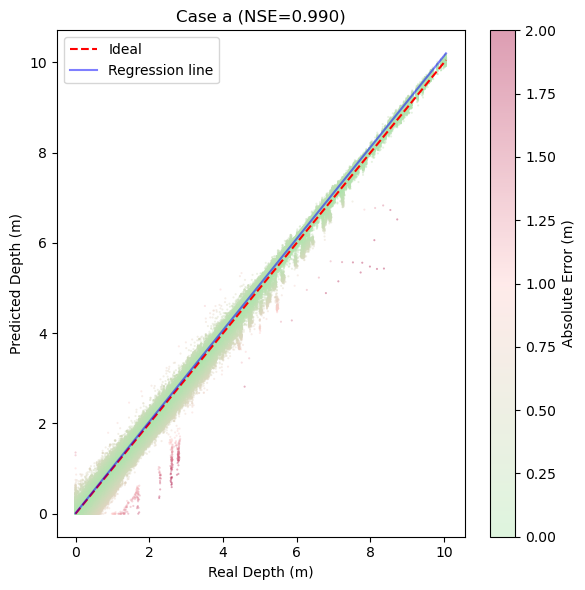

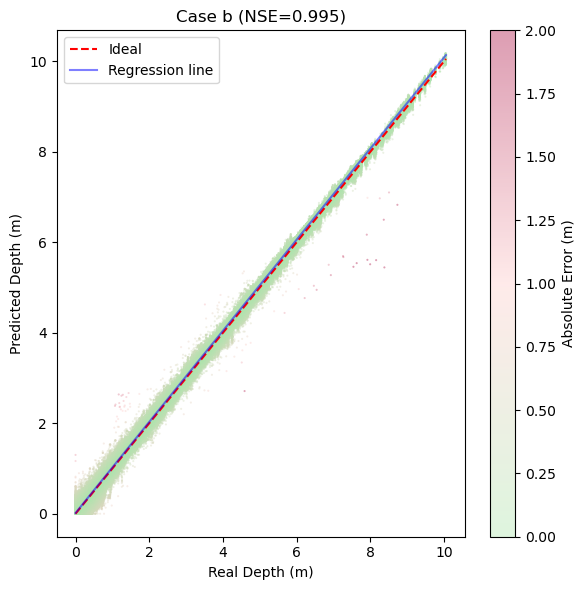

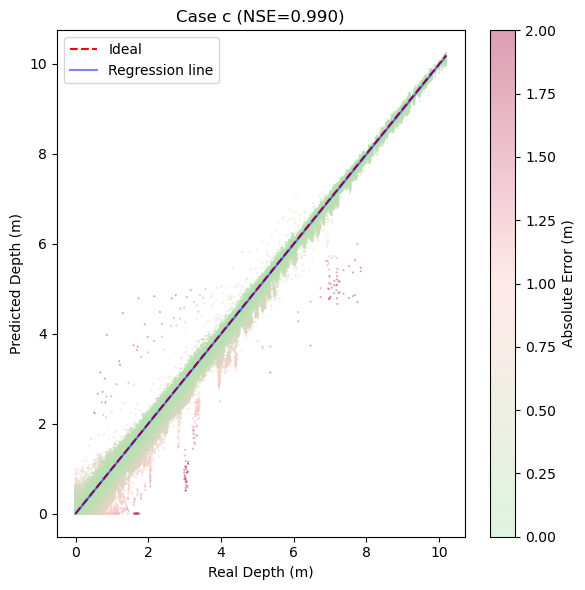

c:\Users\win10\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


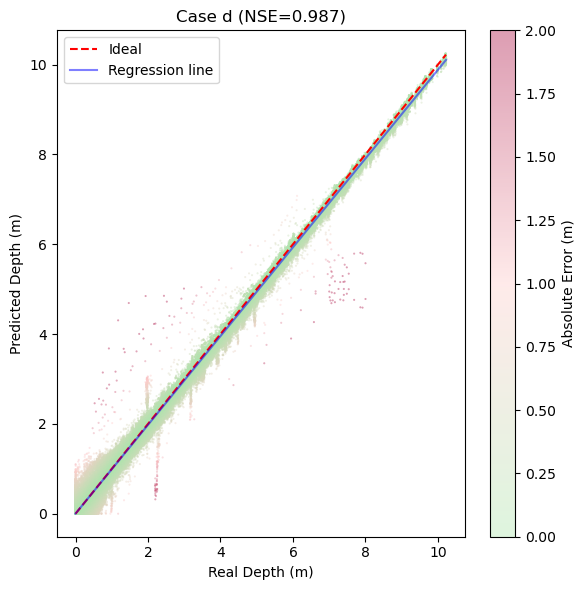

In [51]:
alist=[]
for i in range(1):
    for j in range(1):
        rr=get_pixelwise_depth_pairs_with_r2(modelist[0], [2*i+1,j+1], show_plot=True,names='a')
        alist.append(sum(rr)/24)
blist=[]
for i in range(1):
    for j in range(1):
        rr=get_pixelwise_depth_pairs_with_r2(modelist[0], [2*i+1,j+4], show_plot=True,names='b')
        blist.append(sum(rr)/24)
clist=[]
for i in range(1):
    for j in range(1):
        rr=get_pixelwise_depth_pairs_with_r2(modelist[0], [2*i+4,j+1], show_plot=True,names='c')
        clist.append(sum(rr)/24)
dlist=[]
for i in range(1):
    for j in range(1):
        rr=get_pixelwise_depth_pairs_with_r2(modelist[0], [2*i+4,j+4], show_plot=True,names='d')
        dlist.append(sum(rr)/24)

In [16]:
trainErrlst=[]
trainErrlst0=[]
for i in range(1,11,2):
    for model in modelist1:
        model.eval
        trainErrlst.append(plotmse(model,i,rolling=True))
        trainErrlst0.append(plotmse(model,i,rolling=False))
validateErrlst=[]
validateErrlst0=[]
for i in range(2,3):
    for model in modelist1:
        model.eval
        validateErrlst.append(plotmse(model,i,rolling=True))
        validateErrlst0.append(plotmse(model,i,rolling=False))
testErrlst=[]
testErrlst0=[]
for i in range(4,11,2):
    for model in modelist1:
        model.eval
        testErrlst.append(plotmse(model,i,rolling=True))
        testErrlst0.append(plotmse(model,i,rolling=False))


In [17]:
atrainErrlst=[]
atrainErrlst0=[]
for i in range(1,11,2):
    for model in modelist[0:3]:
        model.eval
        atrainErrlst.append(plotmse(model,i,rolling=True))
        atrainErrlst0.append(plotmse(model,i,rolling=False))
avalidateErrlst=[]
avalidateErrlst0=[]
for i in range(2,3):
    for model in modelist[0:3]:
        model.eval
        avalidateErrlst.append(plotmse(model,i,rolling=True))
        avalidateErrlst0.append(plotmse(model,i,rolling=False))
atestErrlst=[]
atestErrlst0=[]
for i in range(4,11,2):
    for model in modelist[0:3]:
        model.eval
        atestErrlst.append(plotmse(model,i,rolling=True))
        atestErrlst0.append(plotmse(model,i,rolling=False))

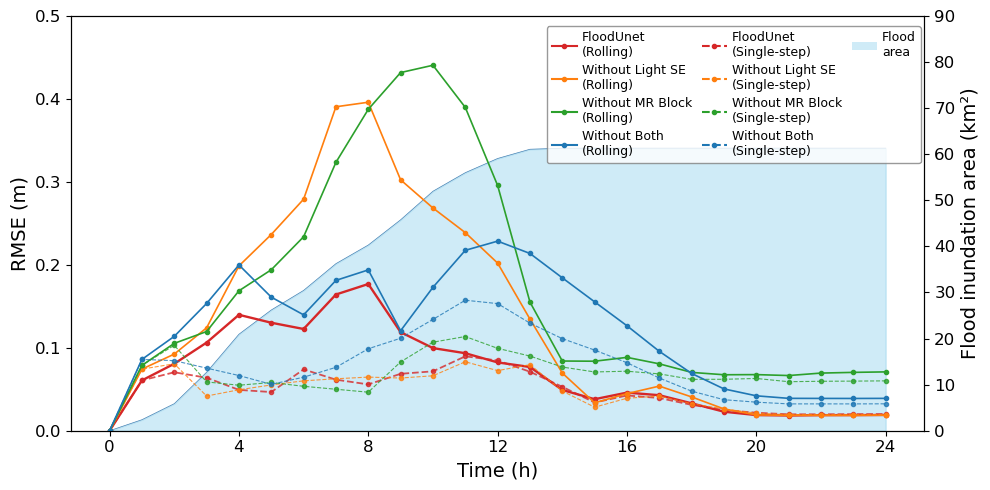

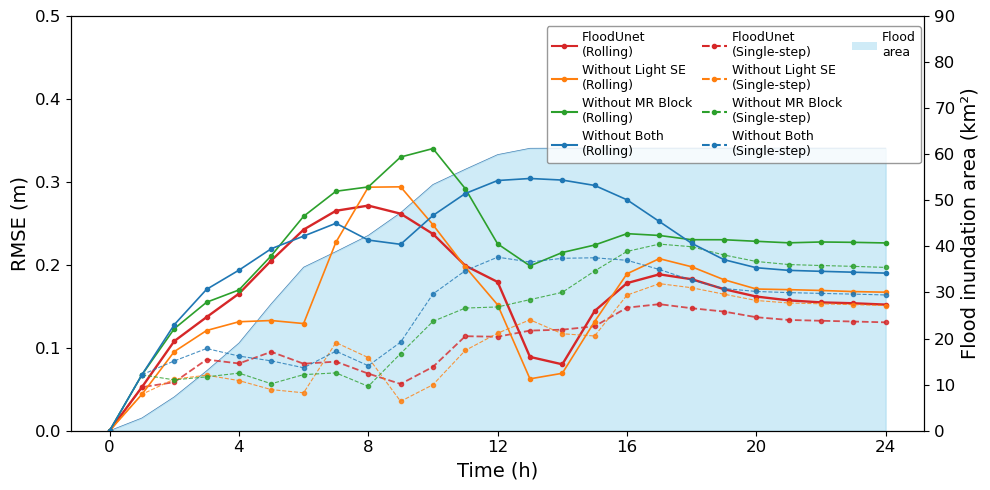

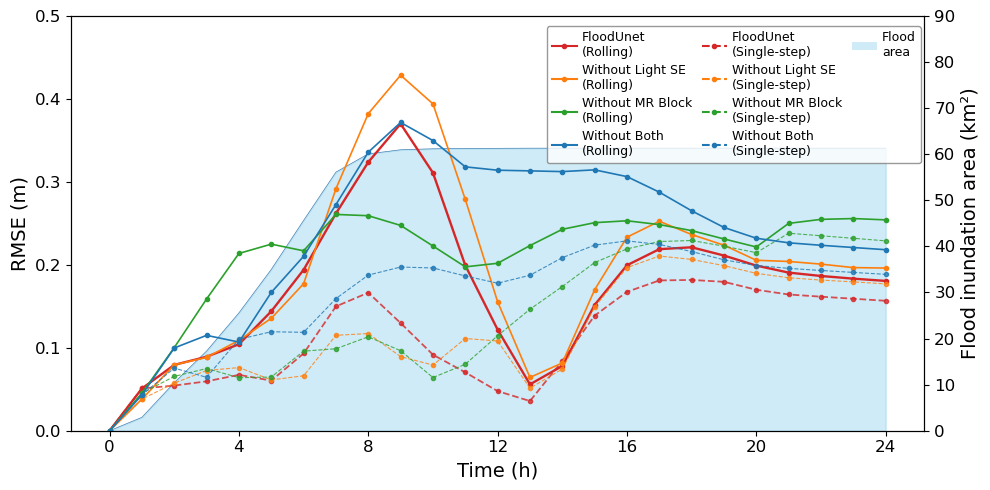

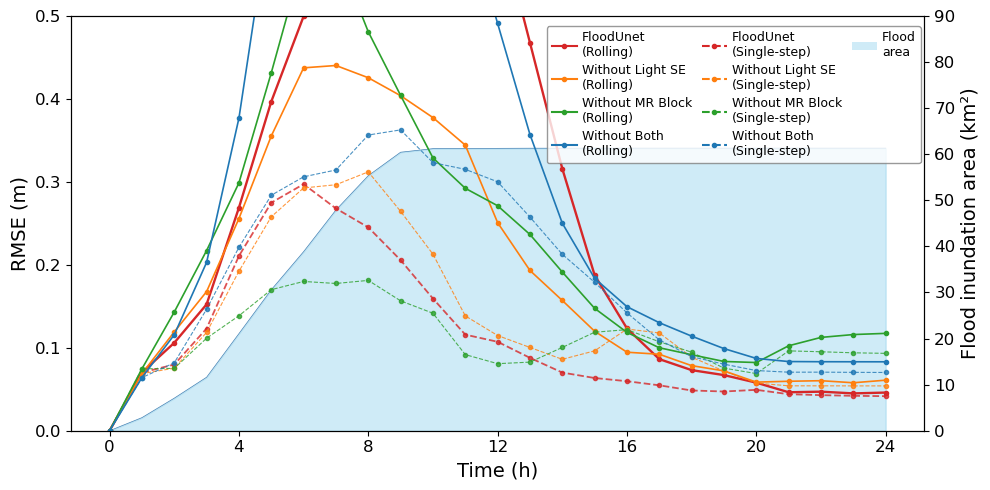

In [ ]:
labels = ['FloodUnet', 'Without Light SE', 'Without MR Block', 'Without Both']
default_colors = ['#d62728', '#ff7f0e', '#2ca02c', '#1f77b4']
marklst = ['.', '.', '.', '.']
t = 24  # Number of prediction steps

for j in range(4):
    fig, ax = plt.subplots(figsize=(10, 5))
    ax2 = ax.twinx()  # Secondary y-axis for flood area

    # -- 1. Compute average flood area over time --
    all_areas = []
    for i in range(4):
        model_data = testErrlst[i + j * 4]
        all_areas.append(model_data['area'])
    avg_area = np.mean(all_areas, axis=0)
    area_km2 = np.insert(avg_area[:t], 0, 0) * 900 / 1e6  # Convert from pixels to km²

    # -- 2. Set z-order: put background behind RMSE curves --
    ax.patch.set_zorder(-1)
    ax2.set_zorder(ax.get_zorder() - 1)
    ax.patch.set_alpha(0)

    # -- 3. Plot flood area (fill and edge) --
    ax2.fill_between(
        range(t + 1), area_km2,
        color='skyblue', alpha=0.4,
        label='Flood inundation area', zorder=0
    )
    ax2.plot(
        range(t + 1), area_km2,
        color='steelblue', linewidth=0.5, zorder=1
    )

    # -- 4. Plot RMSE curves for each model variant (rolling vs. single-step) --
    for i in range(4):
        color = default_colors[i]
        err_rolling = np.sqrt(np.array(testErrlst[i + j * 4]['mse_total']))
        err_single = np.sqrt(np.array(testErrlst0[i + j * 4]['mse_total']))

        # Rolling prediction RMSE
        ax.plot(
            range(t + 1), np.insert(err_rolling[:t], 0, 0),
            marker=marklst[i], linestyle='-', color=color,
            alpha=1, linewidth=1.2 + 0.5 * (i == 0), zorder=2,
            label=f'{labels[i]} (Rolling)'
        )

        # Single-step prediction RMSE
        ax.plot(
            range(t + 1), np.insert(err_single[:t], 0, 0),
            marker=marklst[i], linestyle='--', color=color,
            alpha=0.8, linewidth=0.8 + 0.5 * (i == 0), zorder=2,
            label=f'{labels[i]} (Single-step)'
        )

    # -- 5. Configure axis labels, ticks, and limits --
    ax.set_xlabel('Time (h)', fontsize=14)
    ax.set_ylabel('RMSE (m)', fontsize=14)
    ax.set_xticks(np.arange(0, 25, 4))
    ax.tick_params(axis='both', labelsize=12)
    ax.set_ylim(0, 0.5)
    ax.grid(False)

    ax2.set_ylabel('Flood inundation area (km²)', fontsize=14)
    ax2.tick_params(axis='y', labelsize=12)
    ax2.set_ylim(0, 90)

    # -- 6. Construct custom legend with row-major layout --
    legend_elements = [
        # Rolling predictions
        plt.Line2D([], [], color=default_colors[0], linestyle='-', marker=marklst[0], label=labels[0] + '\n(Rolling)'),
        plt.Line2D([], [], color=default_colors[1], linestyle='-', marker=marklst[1], label=labels[1] + '\n(Rolling)'),
        plt.Line2D([], [], color=default_colors[2], linestyle='-', marker=marklst[2], label=labels[2] + '\n(Rolling)'),
        plt.Line2D([], [], color=default_colors[3], linestyle='-', marker=marklst[3], label=labels[3] + '\n(Rolling)'),
        # Single-step predictions
        plt.Line2D([], [], color=default_colors[0], linestyle='--', marker=marklst[0], label=labels[0] + '\n(Single-step)'),
        plt.Line2D([], [], color=default_colors[1], linestyle='--', marker=marklst[1], label=labels[1] + '\n(Single-step)'),
        plt.Line2D([], [], color=default_colors[2], linestyle='--', marker=marklst[2], label=labels[2] + '\n(Single-step)'),
        plt.Line2D([], [], color=default_colors[3], linestyle='--', marker=marklst[3], label=labels[3] + '\n(Single-step)'),
        # Flood area fill (empty placeholders used for spacing)
        plt.Rectangle((0, 0), 1, 1, fc='skyblue', alpha=0.4, label='Flood\narea'),
        plt.Rectangle((0, 0), 1, 1, fc='skyblue', alpha=0.0, label=''),
        plt.Rectangle((0, 0), 1, 1, fc='skyblue', alpha=0.0, label=''),
        plt.Rectangle((0, 0), 1, 1, fc='skyblue', alpha=0.0, label='')
    ]

    # Reshape legend handles for column-prior layout (3 rows x 4 columns)
    handles_grid = list(np.array(legend_elements).reshape(3, 4).flatten())

    ax.legend(
        handles=handles_grid,
        loc='upper left',
        bbox_to_anchor=(0.55, 0.99),
        ncol=3,
        columnspacing=0.8,
        handletextpad=0.4,
        labelspacing=0.4,
        fontsize=9,
        frameon=True,
        fancybox=True,
        edgecolor='gray',
        facecolor='white'
    )

    plt.tight_layout()
    plt.show()


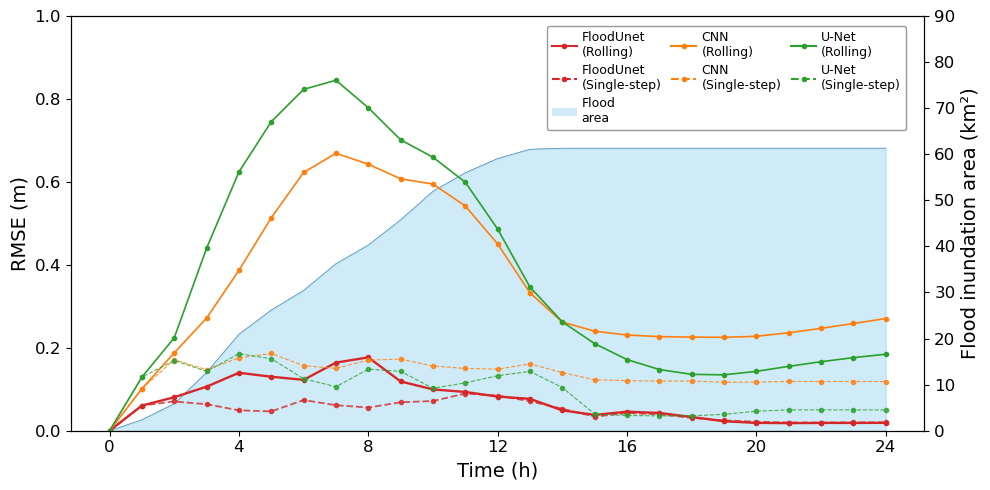

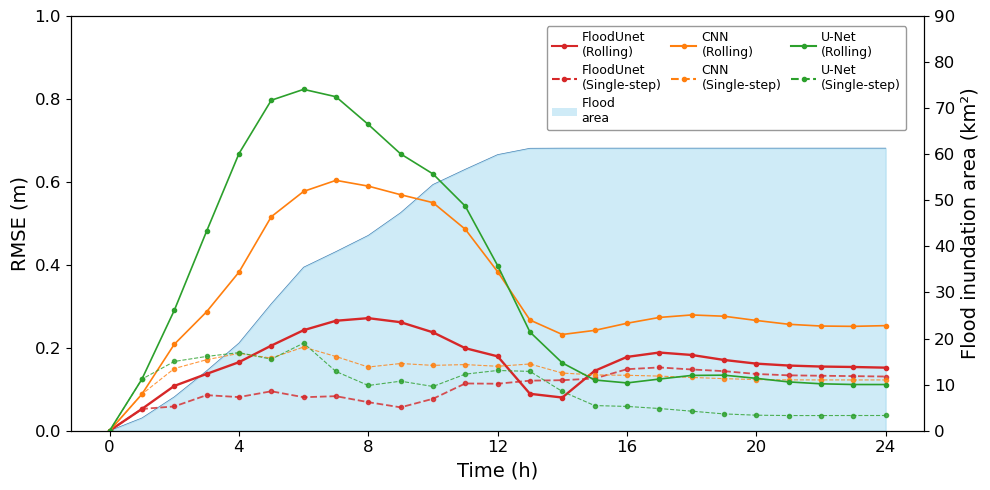

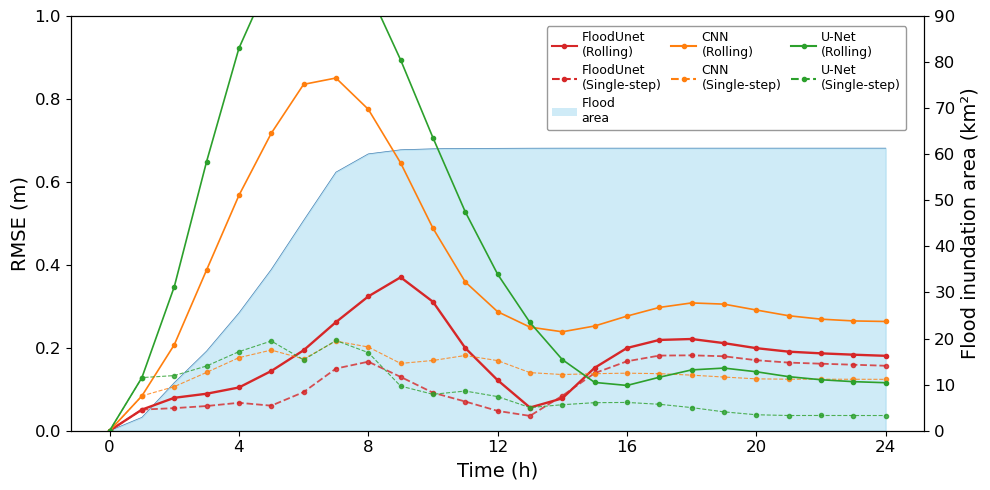

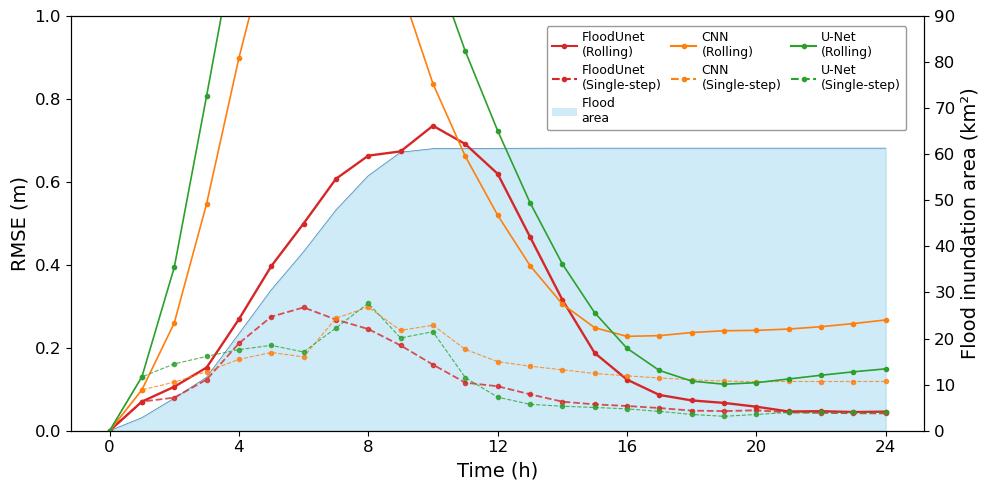

In [ ]:
namelist1 = ['FloodUnet', 'CNN', 'U-Net']
default_colors = ['#d62728', '#ff7f0e', '#2ca02c']
marklst = ['.', '.', '.']
t = 24  # Total number of prediction time steps

for j in range(4):
    fig, ax = plt.subplots(figsize=(10, 5))
    ax2 = ax.twinx()  # Secondary y-axis for flood area

    # 1. Compute mean flood area over time
    all_areas = []
    for i in range(3):
        model_data = atestErrlst[i + j * 3]
        all_areas.append(model_data['area'])
    avg_area = np.mean(all_areas, axis=0)
    area_km2 = np.insert(avg_area[:t], 0, 0) * 900 / 1e6  # Convert from pixels to km²

    # 2. Ensure flood area background is drawn behind RMSE lines
    ax.patch.set_zorder(-1)
    ax2.set_zorder(ax.get_zorder() - 1)
    ax.patch.set_alpha(0)

    # 3. Draw flood area (filled background and border line)
    ax2.fill_between(
        range(t + 1), area_km2,
        color='skyblue', alpha=0.4,
        label='Flood inundation area', zorder=0
    )
    ax2.plot(
        range(t + 1), area_km2,
        color='steelblue', linewidth=0.5, zorder=1
    )

    # 4. Plot RMSE curves for each model: rolling vs. single-step
    for i in range(3):
        color = default_colors[i]
        err_rolling = np.sqrt(np.array(atestErrlst[i + j * 3]['mse_total']))
        err_single = np.sqrt(np.array(atestErrlst0[i + j * 3]['mse_total']))

        # Rolling prediction
        ax.plot(
            range(t + 1), np.insert(err_rolling[:t], 0, 0),
            marker=marklst[i], linestyle='-', color=color,
            alpha=1, linewidth=1.2 + 0.5 * (i == 0), zorder=2,
            label=f'{namelist1[i]} (Rolling)'
        )

        # Single-step prediction
        ax.plot(
            range(t + 1), np.insert(err_single[:t], 0, 0),
            marker=marklst[i], linestyle='--', color=color,
            alpha=0.8, linewidth=0.8 + 0.5 * (i == 0), zorder=2,
            label=f'{namelist1[i]} (Single-step)'
        )

    # 5. Configure axis labels and appearance
    ax.set_xlabel('Time (h)', fontsize=14)
    ax.set_ylabel('RMSE (m)', fontsize=14)
    ax.set_xticks(np.arange(0, 25, 4))
    ax.tick_params(axis='both', labelsize=12)
    ax.set_ylim(0, 1)
    ax.grid(False)

    ax2.set_ylabel('Flood inundation area (km²)', fontsize=14)
    ax2.tick_params(axis='y', labelsize=12)
    ax2.set_ylim(0, 90)

    # 6. Construct composite legend (rolling, single-step, flood area)
    legend_elements = [
        # Rolling predictions
        plt.Line2D([], [], color=default_colors[0], linestyle='-', marker=marklst[0], label='FloodUnet\n(Rolling)'),
        plt.Line2D([], [], color=default_colors[1], linestyle='-', marker=marklst[1], label='CNN\n(Rolling)'),
        plt.Line2D([], [], color=default_colors[2], linestyle='-', marker=marklst[2], label='U-Net\n(Rolling)'),
        # Single-step predictions
        plt.Line2D([], [], color=default_colors[0], linestyle='--', marker=marklst[0], label='FloodUnet\n(Single-step)'),
        plt.Line2D([], [], color=default_colors[1], linestyle='--', marker=marklst[1], label='CNN\n(Single-step)'),
        plt.Line2D([], [], color=default_colors[2], linestyle='--', marker=marklst[2], label='U-Net\n(Single-step)'),
        # Flood area patch (with blank placeholders to align grid)
        plt.Rectangle((0, 0), 1, 1, fc='skyblue', alpha=0.4, label='Flood\narea'),
        plt.Rectangle((0, 0), 1, 1, fc='skyblue', alpha=0.0, label=''),
        plt.Rectangle((0, 0), 1, 1, fc='skyblue', alpha=0.0, label='')
    ]

    # Reshape legend to column-first layout (3 rows × 3 columns)
    handles_grid = list(np.array(legend_elements).reshape(3, 3).T.flatten())

    ax.legend(
        handles=handles_grid,
        loc='upper left',
        bbox_to_anchor=(0.55, 0.99),
        ncol=3,
        columnspacing=0.8,
        handletextpad=0.4,
        labelspacing=0.4,
        fontsize=9,
        frameon=True,
        fancybox=True,
        edgecolor='gray',
        facecolor='white'
    )

    plt.tight_layout()
    plt.show()
